### Food Image Classification With a CNN

In [41]:
# load the necessary packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

import itertools

import os
import numpy as np
import matplotlib.pyplot as plt

### Load and Preprocess Data for Model

In [15]:
batch_size = 25
epochs = 25
IMG_HEIGHT = 256
IMG_WIDTH = 256
train_dir = '../data/resized/train'
test_dir = '../data/resized/test'
valid_dir = '../data/resized/validation'
dropout_rate = 0.15

In [18]:
train_image_generator = ImageDataGenerator(rescale=1./255)
valid_image_generator = ImageDataGenerator(rescale=1./255)

In [4]:
# initialize training image iterator
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_HEIGHT,IMG_WIDTH))

Found 75750 images belonging to 101 classes.


In [19]:
# initialize test image iterator
valid_data_gen = valid_image_generator.flow_from_directory(batch_size=batch_size,
                                                          directory=valid_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_HEIGHT,IMG_WIDTH))

Found 12625 images belonging to 101 classes.


In [6]:
# setup model architechture

model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    Conv2D(256, 5, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    Conv2D(512, 5, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Dropout(rate=dropout_rate),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(101,activation=None)
])

In [7]:
# compile model
model.compile(optimizer='adam',
              loss='cosine_similarity',
              metrics=['accuracy'])

In [8]:
# initialize early stopping callback
es_callback = EarlyStopping(monitor="val_loss", patience=3)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       5

In [10]:
# train model
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=75750//batch_size,
    epochs=epochs,
    validation_data=valid_data_gen,
    validation_steps=12625//batch_size,
    workers=1,
    use_multiprocessing=False,
    callbacks=[es_callback]
)

Epoch 1/25
3030/3030 [==============================] - 1335s 441ms/step - loss: -0.1464 - accuracy: 0.0765 - val_loss: -0.1747 - val_accuracy: 0.1001
Epoch 2/25
3030/3030 [==============================] - 1315s 434ms/step - loss: -0.2166 - accuracy: 0.1472 - val_loss: -0.2569 - val_accuracy: 0.1949
Epoch 3/25
3030/3030 [==============================] - 1313s 433ms/step - loss: -0.2821 - accuracy: 0.2268 - val_loss: -0.2698 - val_accuracy: 0.2076
Epoch 4/25
3030/3030 [==============================] - 1308s 432ms/step - loss: -0.3492 - accuracy: 0.3082 - val_loss: -0.3463 - val_accuracy: 0.2885
Epoch 5/25
3030/3030 [==============================] - 1313s 433ms/step - loss: -0.4190 - accuracy: 0.3937 - val_loss: -0.3948 - val_accuracy: 0.3512
Epoch 6/25
3030/3030 [==============================] - 1320s 435ms/step - loss: -0.4845 - accuracy: 0.4763 - val_loss: -0.4089 - val_accuracy: 0.3664
Epoch 7/25
3030/3030 [==============================] - 1326s 438ms/step - loss: -0.5423 - acc

The model early stopped on the 12th epoch because there were no longer noticeable gains in accuracy or minimization of loss for 3 epochs, as configured above.

In [13]:
# if there is not a saved model, save model for future use
if not os.path.isdir('../saved_models'):
    os.makedirs('../saved_models')
model.save('../saved_models/CNN_MODEL_V4.h5')

### Visualizing Results

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


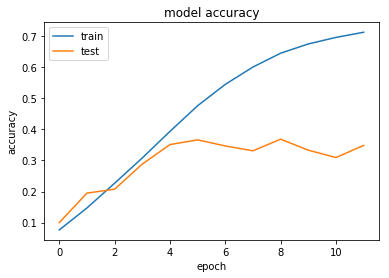

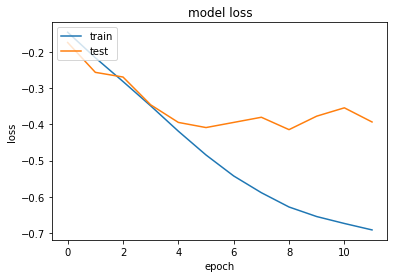

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# setup test data generator
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                          directory=test_dir,
                                                          shuffle=False,
                                                          target_size=(IMG_HEIGHT,IMG_WIDTH))

Found 12625 images belonging to 101 classes.


In [35]:
# make predictions on test set
probabilities = model.predict_generator(test_data_gen,
                                        steps=12625//batch_size)

In [36]:
# set true labels and intialize class names
y_test = test_data_gen.classes
class_names = []
for key in test_data_gen.class_indices.keys():
    class_names.append(key)

In [37]:
y_pred = np.argmax(probabilities, axis=1)
print("Total number of test pictures: {}".format(len(y_pred)))

Total number of test pictures: 12625


#### Get stats on prediction per class

In [38]:
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report
                         precision    recall  f1-score   support

              apple_pie       0.10      0.16      0.13       125
         baby_back_ribs       0.33      0.44      0.38       125
                baklava       0.36      0.26      0.30       125
         beef_carpaccio       0.77      0.48      0.59       125
           beef_tartare       0.31      0.21      0.25       125
             beet_salad       0.30      0.33      0.31       125
               beignets       0.68      0.55      0.61       125
               bibimbap       0.72      0.54      0.61       125
          bread_pudding       0.17      0.22      0.19       125
      breakfast_burrito       0.07      0.14      0.10       125
             bruschetta       0.31      0.20      0.24       125
           caesar_salad       0.45      0.34      0.39       125
                cannoli       0.50      0.25      0.33       125
          caprese_salad       0.42      0.25      0.31       125
  

#### Plot confusion Matrix

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[20  1  2 ...  1  0  2]
 [ 1 55  0 ...  1  0  0]
 [11  2 32 ...  0  0  0]
 ...
 [ 5  0  3 ... 46  1  1]
 [ 0  0  1 ...  0 28  1]
 [ 4  0  1 ...  0  0 45]]


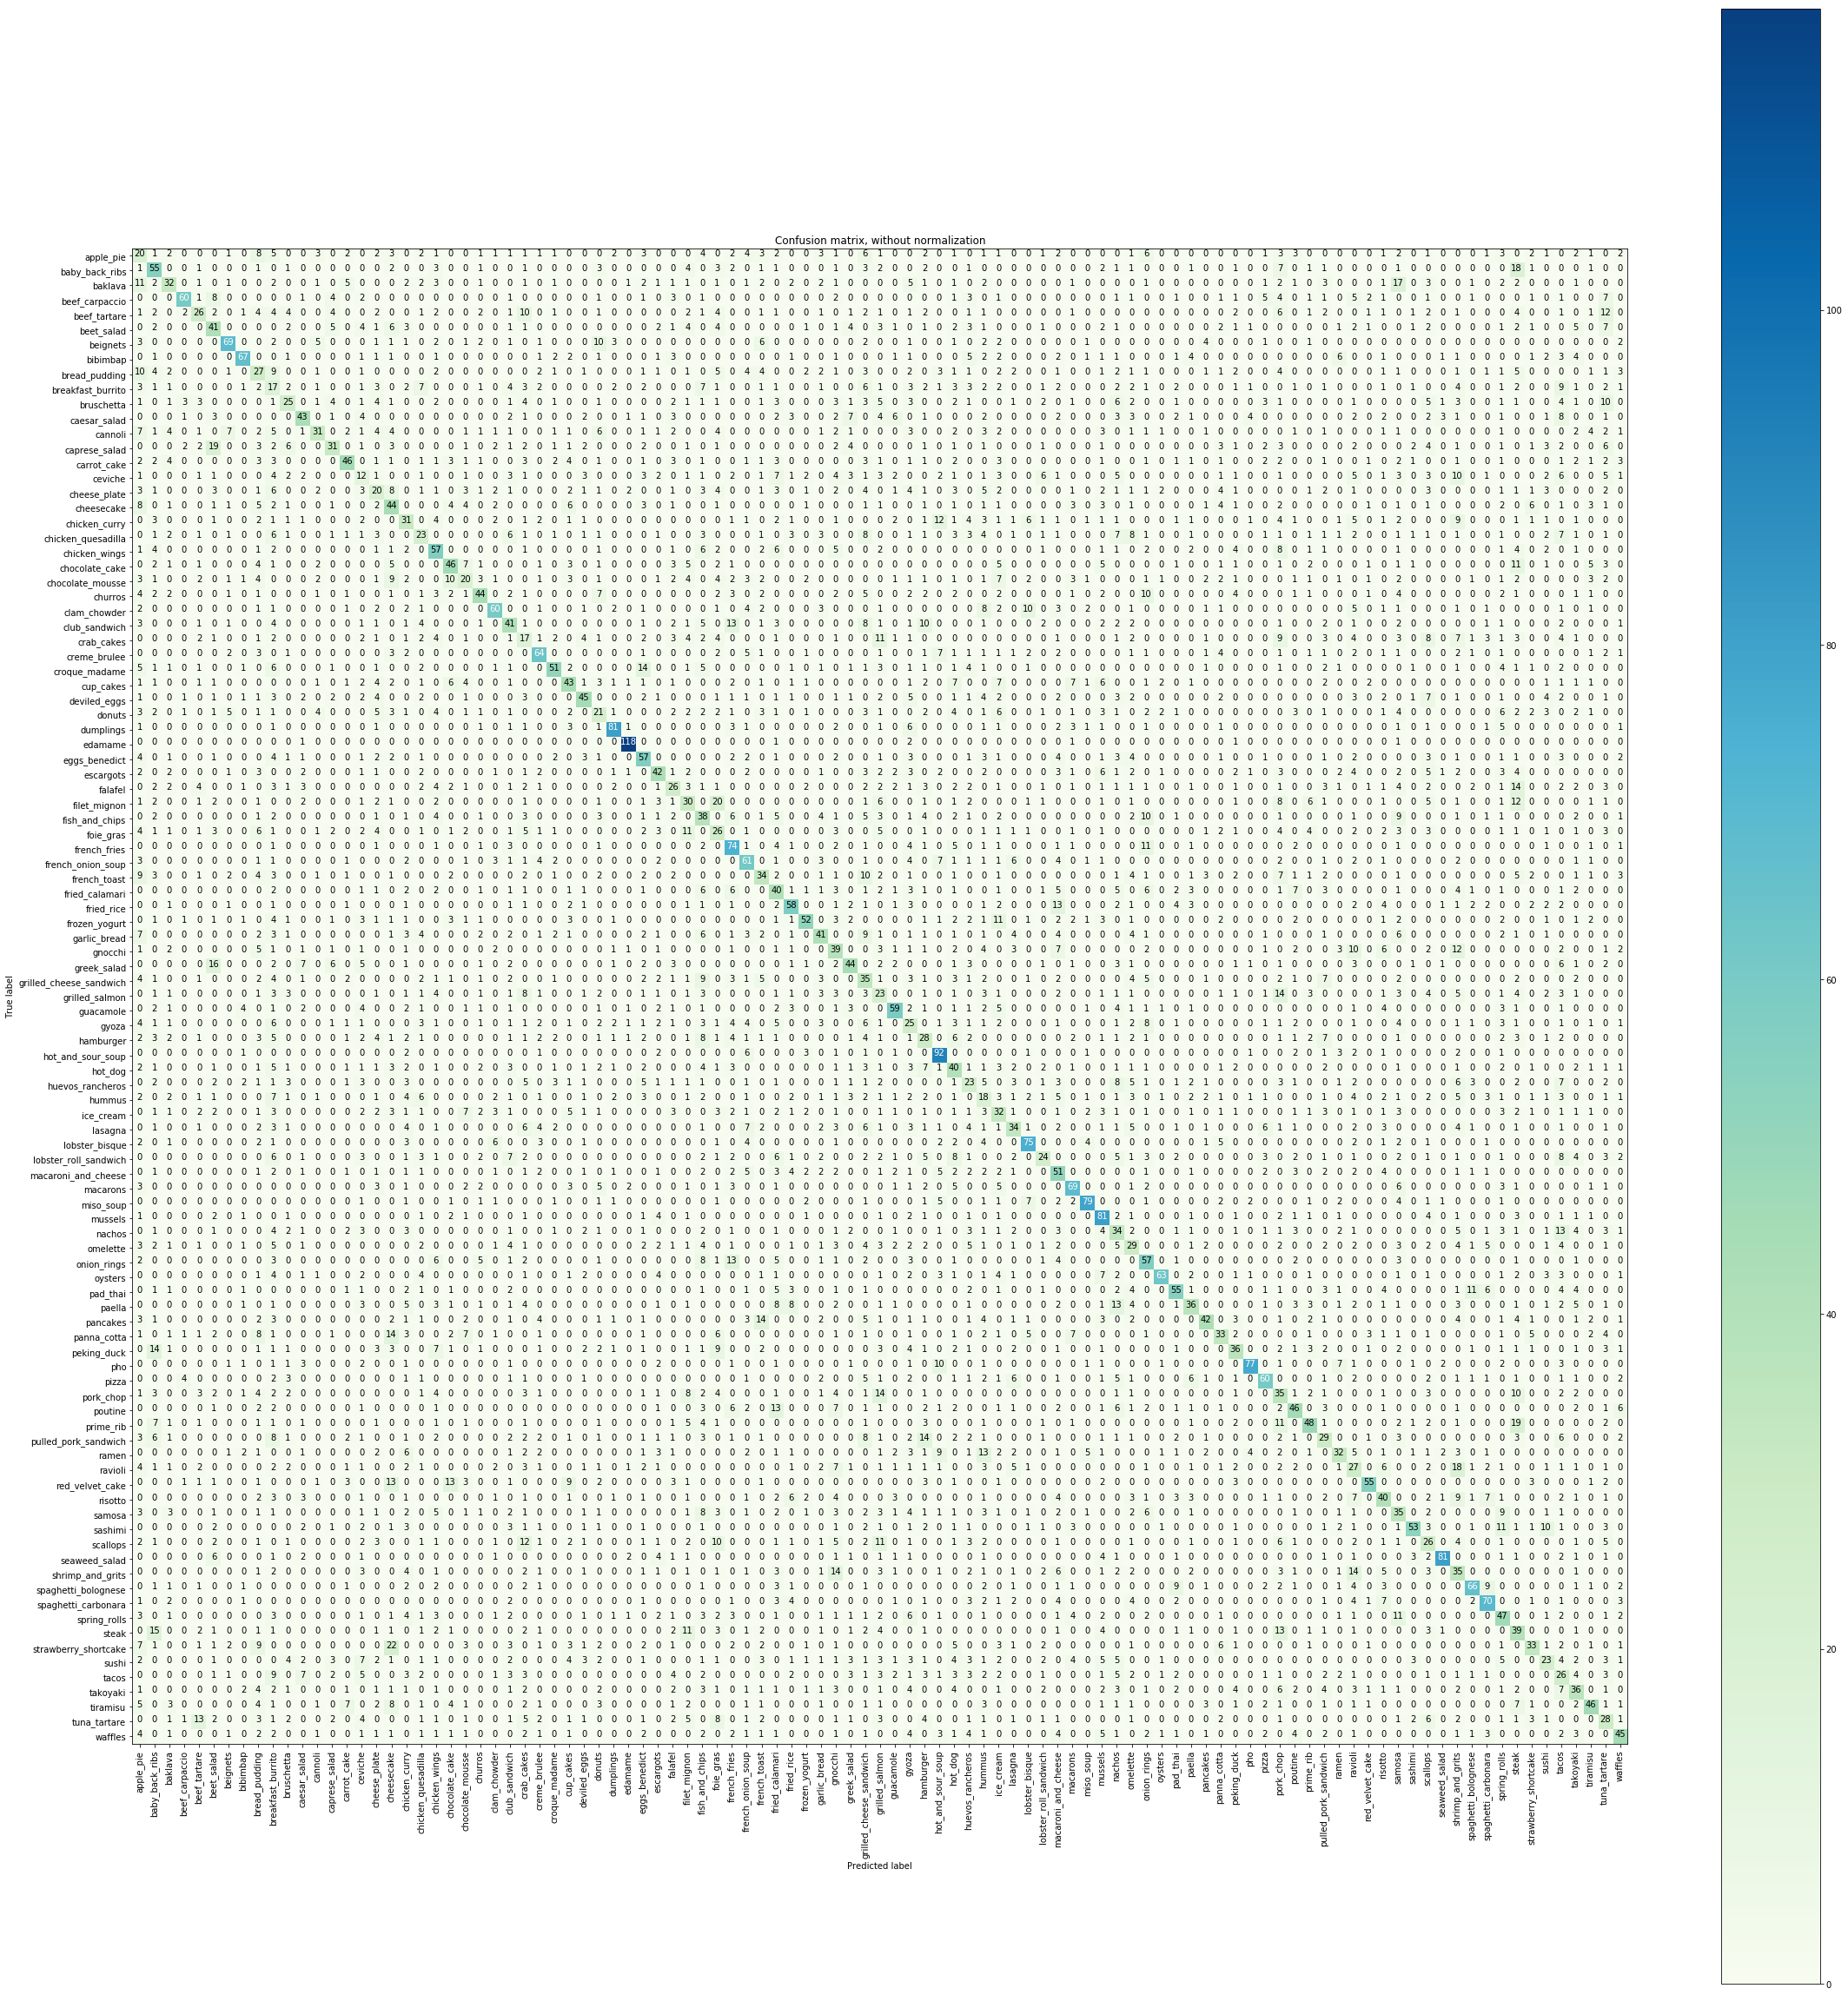

In [42]:
plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.GnBu)
plt.show()

This confusion martrix plots the true identifications on the diagonal and the wrong classificationson every other spot. The Columns represent the predicted class and the rows represent the actual class.

In [43]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [44]:
auc = multiclass_roc_auc_score(y_test, y_pred)
print("Multi-Class AUC Score is: {}".format(auc))

Multi-Class AUC Score is: 0.6710400000000001


There is a multi-class AUC score of .69 which means the predictions are accurate. However as seen above this is not always the case.

In [49]:
test_data_gen.filepaths[0]

'../data/resized/test\\apple_pie\\1011328.jpg'

In [72]:
def show_images_prediction(food_class,y_test, page=0):
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(12, 8)
    fig.tight_layout()
    start_i = (class_names.index(food_class) * 125) + (page * 20)
    for i, ax in enumerate(axes.flat):

        im = ax.imshow(plt.imread(test_data_gen.filepaths[i+start_i]))
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        predicted = class_names[y_pred[i+start_i]]
        match = predicted ==  class_names[y_test[start_i + i]]
        ec = (1, .5, .5)
        fc = (1, .8, .8)
        if match:
            ec = (0, .6, .1)
            fc = (0, .7, .2)
        # predicted label
        ax.text(0, 270, 'P: ' + predicted, size=10, rotation=0,
            ha="left", va="top",
             bbox=dict(boxstyle="round",
                   ec=ec,
                   fc=fc,
                   )
             )
        if not match:
            # true label
            ax.text(0, 320, 'A: ' + class_names[y_test[start_i + i]], size=10, rotation=0,
                ha="left", va="top",
                 bbox=dict(boxstyle="round",
                       ec=ec,
                       fc=fc,
                       )
                 )
    plt.subplots_adjust(left=0, wspace=1, hspace=0)
    plt.show()

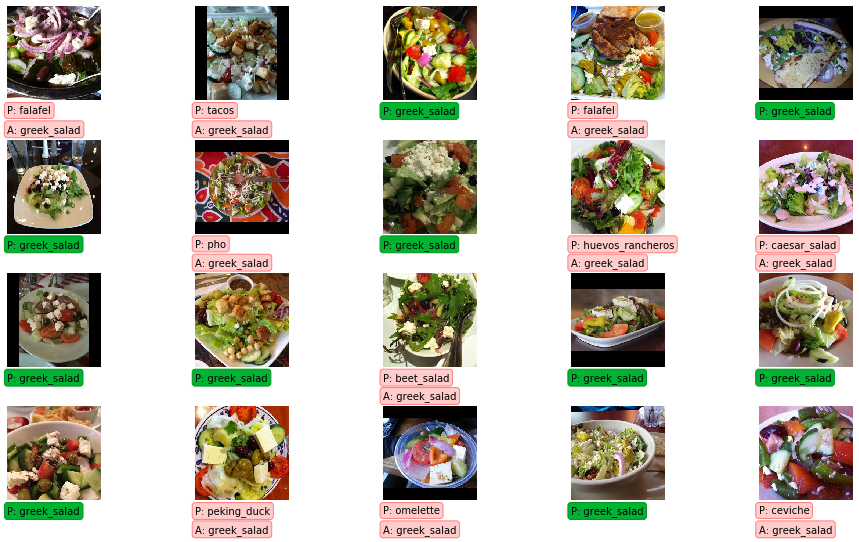

In [78]:
# change the first parameter to the class label you would like to examine.
# if you would like to check different images of the class increase the page number
show_images_prediction('greek_salad', y_test, page=0)

After observing some different pages above, it is clear that building a food classifier is not easy. With the understanding of how a CNN gets features and uses them to build predictions, it is possible to see why the model made some of the wrong predictions that it did. 

Some other food labels may have very similar shapes and colors, which could trick the model into thinking the image was of a different class.

Or in the case of sushi, there are very different type of shapes, colors, and arrangements of the food.

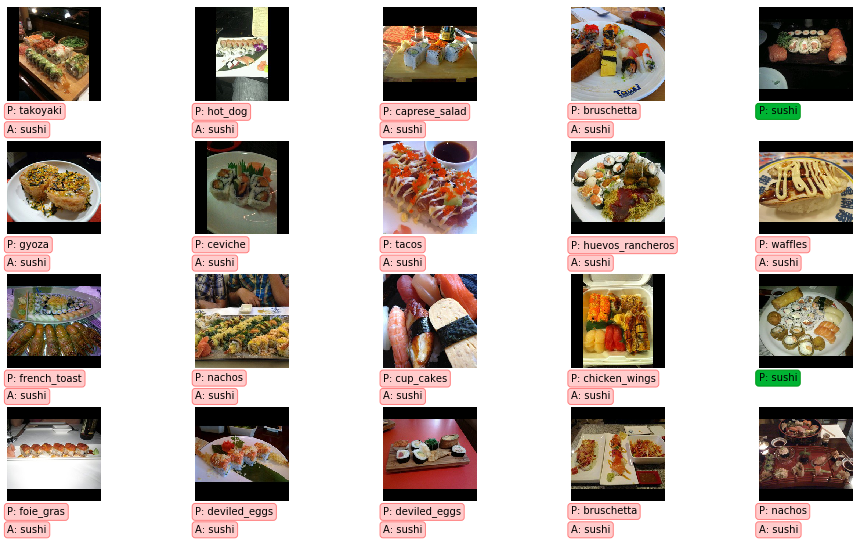

In [75]:
# change the first parameter to the class label you would like to examine.
# if you would like to check different images of the class increase the page number
show_images_prediction('sushi', y_test, page=0)